# Here we will look at the dynamics of the sources of the publications in the dataset.

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pickle

In [3]:
# read in the dataframe
df = pd.read_pickle("peds_spine_v1_from_R.pkl")
# inspect the dataframe
df.head()

,AU,DE,ID,C1,CR,AB,PA,affiliations,AR,EM,...,web.of.science.index,PY,RP,DB,J9,AU_UN,AU1_UN,AU_UN_NR,SR_FULL,SR
0,SAKAI N;YAMADA H;NISHIMURA Y;SHIRAKAMI S;FUTAM...,CAVERNOUS ANGIOMA; SURGERY; LITERATURE REVIEW,HEMANGIOMA; MALFORMATIONS; DIAGNOSIS; CHILDREN...,"SAKAI, N (CORRESPONDING AUTHOR), GIFU UNIV, SC...","CHADDUCK WM, 1985, NEUROSURGERY, V16, P189, DO...",THREE CASES OF SYMPTOMATIC CAVERNOUS ANGIOMA O...,"233 SPRING ST, NEW YORK, NY 10013 USA",NaN,NaN,NaN,...,SCIENCE CITATION INDEX EXPANDED (SCI-EXPANDED),1992,"SAKAI, N (CORRESPONDING AUTHOR), GIFU UNIV, SC...",ISI,CHILDS NERV SYST,GIFU UNIV,GIFU UNIV,NaN,"SAKAI N, 1992, CHILDS NERV SYST","SAKAI N, 1992, CHILDS NERV SYST"
1,TEWARI MK;TRIPATHI LN;MATHURIYA SN;KHANDELWAL ...,SPONTANEOUS SPINAL EXTRADURAL HEMATOMA; SPINAL...,EPIDURAL HEMATOMA; PARAPLEGIA; RECOVERY,"POSTGRAD INST MED EDUC \& RES,DEPT NEUROSURG,C...","BRAWN LA, 1986, POSTGRAD MED J, V62, P885, DOI...",THREE YOUNG CHILDREN WHO PRESENTED WITH ACUTE ...,"175 FIFTH AVE, NEW YORK, NY 10010",POST GRADUATE INSTITUTE OF MEDICAL EDUCATION \...,NaN,NaN,...,SCIENCE CITATION INDEX EXPANDED (SCI-EXPANDED),1992,"POSTGRAD INST MED EDUC \& RES,DEPT NEUROSURG,C...",ISI,CHILDS NERV SYST,POSTGRAD INST MED EDUC AND RES;POSTGRAD INST M...,POSTGRAD INST MED EDUC AND RES,NaN,"TEWARI MK, 1992, CHILDS NERV SYST","TEWARI MK, 1992, CHILDS NERV SYST"
2,MIGLIORE A;CALZOLARI F;MARZOLA A;GHADIRPOUR MM,PEDIATRIC CRANIOPHARYNGIOMA; III-VENTRICLE; TR...,INTRAVENTRICULAR CRANIOPHARYNGIOMA; TOTAL REMOVAL,"MIGLIORE, A (CORRESPONDING AUTHOR), UNIV FERRA...","ALTINORS N, 1984, J NEUROSURG, V60, P842, DOI ...",A CASE OF INTRINSIC III VENTRICLE CRANIOPHARYN...,"175 FIFTH AVE, NEW YORK, NY 10010",UNIVERSITY OF FERRARA; UNIVERSITY OF FERRARA; ...,NaN,NaN,...,SCIENCE CITATION INDEX EXPANDED (SCI-EXPANDED),1992,"MIGLIORE, A (CORRESPONDING AUTHOR), UNIV FERRA...",ISI,CHILDS NERV SYST,UNIV FERRARA;UNIV FERRARA,UNIV FERRARA,NaN,"MIGLIORE A, 1992, CHILDS NERV SYST","MIGLIORE A, 1992, CHILDS NERV SYST"
3,SCHWEITZER JS;BATZDORF U,CAUDA EQUINA; EPENDYMOMA; MAGNETIC RESONANCE I...,SACROCOCCYGEAL MYXOPAPILLARY EPENDYMOMA; SPINA...,"UNIV CALIF LOS ANGELES,CTR HLTH SCI,DIV NEUROS...","BARONE BM, 1970, J NEUROSURG, V33, P428, DOI 1...",NEW DIAGNOSTIC IMAGING TECHNIQUES MAKE POSSIBL...,"351 WEST CAMDEN ST, BALTIMORE, MD 21201-2436",UNIVERSITY OF CALIFORNIA SYSTEM; UNIVERSITY OF...,NaN,NaN,...,SCIENCE CITATION INDEX EXPANDED (SCI-EXPANDED),1992,"UNIV CALIF LOS ANGELES,CTR HLTH SCI,DIV NEUROS...",ISI,NEUROSURGERY,UNIV CALIF LOS ANGELES;UNIV CALIF LOS ANGELES;...,UNIV CALIF LOS ANGELES,NaN,"SCHWEITZER JS, 1992, NEUROSURGERY","SCHWEITZER JS, 1992, NEUROSURGERY"
4,WONG CC;PEREIRA B;PHO RWH,NaN,NaN,"NATL UNIV SINGAPORE HOSP,DEPT ORTHOPAED SURG,L...",NaN,FOUR CASES OF SYMPTOMATIC CERVICAL DISC CALCIF...,"227 EAST WASHINGTON SQ, PHILADELPHIA, PA 19106",NATIONAL UNIVERSITY OF SINGAPORE,NaN,NaN,...,SCIENCE CITATION INDEX EXPANDED (SCI-EXPANDED),1992,"NATL UNIV SINGAPORE HOSP,DEPT ORTHOPAED SURG,L...",ISI,SPINE,NATL UNIV SINGAPORE HOSP,NATL UNIV SINGAPORE HOSP,NaN,"WONG CC, 1992, SPINE","WONG CC, 1992, SPINE"


In [4]:
# define a function to count the number of papers published in each journal per year

def count_journal_representation_per_year(df):
    # Group by year and journal, count the size of each group
    group_df = df.groupby(["PY", "J9"]).size().reset_index(name="count")

    # Rename the columns to better reflect what they represent
    group_df.columns = ["Publication_Year", "Journal", "Count"]

    return group_df

# call the function and create a new dataframe
source_dynamics = count_journal_representation_per_year(df)

# inspect the dataframe
source_dynamics.head()

,Publication_Year,Journal,Count
0,1902,BRAIN,1
1,1909,LANCET,2
2,1910,BRAIN,1
3,1910,LANCET,1
4,1912,BRAIN,1


In [16]:
# here we will create a leaderboard of the top journals per year

# Create a DataFrame with all combinations of years and journals
all_years = pd.DataFrame(
    {
        "Publication_Year": range(
            source_dynamics.Publication_Year.min(),
            source_dynamics.Publication_Year.max() + 1,
        )
    }
)
all_journals = pd.DataFrame({"Journal": source_dynamics.Journal.unique()})
all_combinations = (
    all_years.assign(key=1).merge(all_journals.assign(key=1)).drop(columns="key")
)

# Merge the original DataFrame onto this, replacing NaN values with 0 (indicating journals that didn't publish that year)
full_data = pd.merge(
    all_combinations, source_dynamics, how="left", on=["Publication_Year", "Journal"]
).fillna(0)

# Now compute the cumulative counts and leaderboard
full_data["Cumulative_Count"] = full_data.groupby("Journal")["Count"].cumsum()
full_data = full_data.sort_values(
    by=["Publication_Year", "Cumulative_Count"], ascending=[True, False]
)
# Calculate the rank but only when Cumulative_Count > 0
full_data["Leaderboard"] = np.where(
    full_data["Cumulative_Count"] > 0,
    full_data.groupby("Publication_Year")["Cumulative_Count"].rank(
        method="min", ascending=False
    ),
    np.nan,
)

# inspect the dataframe for Journal == 'J NEUROSURG-PEDIATR' over the last 15 years as an example
full_data[full_data.Journal == "J NEUROSURG-PEDIATR"].tail(15)

,Publication_Year,Journal,Count,Cumulative_Count,Leaderboard
6570,2009,J NEUROSURG-PEDIATR,25.0,48.0,12.0
6631,2010,J NEUROSURG-PEDIATR,26.0,74.0,9.0
6692,2011,J NEUROSURG-PEDIATR,30.0,104.0,8.0
6753,2012,J NEUROSURG-PEDIATR,27.0,131.0,8.0
6814,2013,J NEUROSURG-PEDIATR,25.0,156.0,8.0
6875,2014,J NEUROSURG-PEDIATR,33.0,189.0,6.0
6936,2015,J NEUROSURG-PEDIATR,34.0,223.0,5.0
6997,2016,J NEUROSURG-PEDIATR,39.0,262.0,5.0
7058,2017,J NEUROSURG-PEDIATR,30.0,292.0,4.0
7119,2018,J NEUROSURG-PEDIATR,38.0,330.0,4.0


In [17]:
source_dynamics = full_data # rename the dataframe for clarity

# save the dataframe as a csv for inspection
source_dynamics.to_csv("peds_spine_source_dynamics.csv", index=False)

# save the dataframe as a pickle to preserve the data types
with open("peds_spine_source_dynamics.pkl", "wb") as f:
    pickle.dump(source_dynamics, f)

## Preparing figure 2

In [21]:
sns.set_context("talk")
sns.set_palette("tab20")

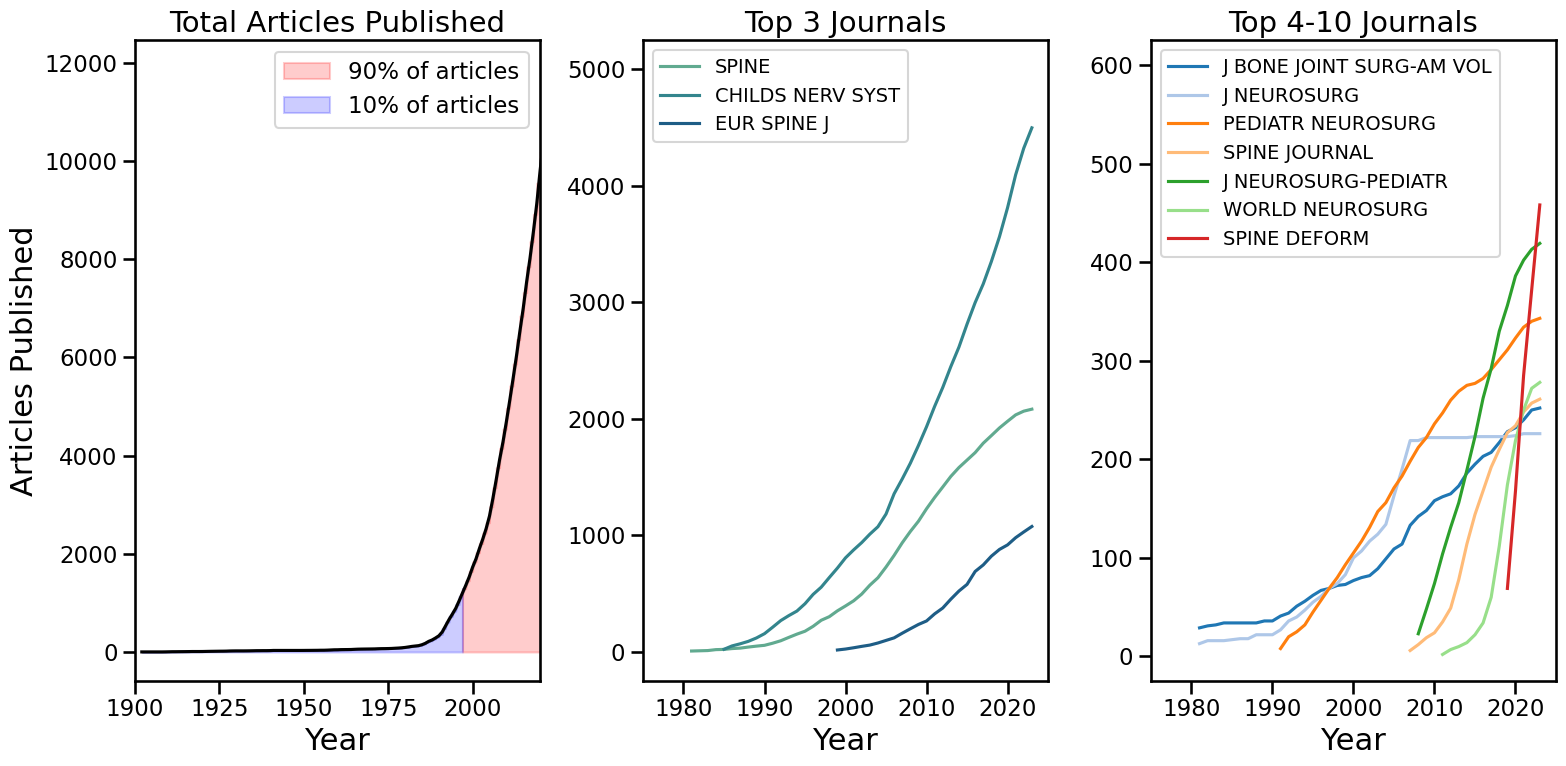

In [28]:
def set_ax_properties(ax, xlabel, ylabel, title, xlim=None, ylim=None):
    ax.set_xlabel(xlabel, size=22)
    ax.set_ylabel(ylabel, size=22)
    ax.set_title(title, size=21)
    
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)

def plot_data_on_ax(data, x, y, hue, palette, ax):
    sns.lineplot(data=data, x=x, y=y, hue=hue, palette=palette, ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    order = [labels.index(journal) for journal in data[hue].unique()]
    ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], prop={"size": 14})

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8))

# Preprocess the data
# sort by year
source_dynamics_sorted = source_dynamics.sort_values(by="Publication_Year")
# calculate cumulative count
source_dynamics_sorted["Cumulative_Count"] = source_dynamics_sorted["Count"].cumsum()
# calculate the year at which 90% of articles were published
year_pct = source_dynamics_sorted[source_dynamics_sorted["Cumulative_Count"] > source_dynamics_sorted["Cumulative_Count"].max() * 0.1]["Publication_Year"].min() 

# Plot the data for ax1
sns.lineplot(data=source_dynamics_sorted, x="Publication_Year", y="Cumulative_Count", color="black", ax=ax1)
# Fill in the area under the curve
# for the 90% of articles published before year_pct, fill in the area above the curve
ax1.fill_between(source_dynamics_sorted["Publication_Year"], source_dynamics_sorted["Cumulative_Count"], where=(source_dynamics_sorted["Publication_Year"] >= year_pct), color="red", alpha=0.2)
# for the 10% of articles published after year_pct, fill in the area below the curve
ax1.fill_between(source_dynamics_sorted["Publication_Year"], source_dynamics_sorted["Cumulative_Count"], where=(source_dynamics_sorted["Publication_Year"] <= year_pct), color="blue", alpha=0.2)
# add a legend
ax1.legend(handles=[Patch(color="red", alpha=0.2, label="90% of articles"), Patch(color="blue", alpha=0.2, label="10% of articles")])

# Plot the data for ax2 and ax3
filtered_data = top_journals_data[top_journals_data["Cumulative_Count"] > 0]
# get the top 3 journals for ax2
plot_data_on_ax(filtered_data.query("`Publication_Year` > 1980 and `Journal` in @top_3_journals"), "Publication_Year", "Cumulative_Count", "Journal", sns.color_palette("crest", len(top_3_journals)), ax2)
# get the remaining journals for ax3
plot_data_on_ax(filtered_data.query("`Publication_Year` > 1980 and `Journal` in @remaining_journals"), "Publication_Year", "Cumulative_Count", "Journal", sns.color_palette("tab20", len(remaining_journals)), ax3)

# Set properties
set_ax_properties(ax1, "Year", "Articles Published", "Total Articles Published", xlim=[1900, 2020], ylim=None)
set_ax_properties(ax2, "Year", "", "Top 3 Journals", xlim=[1975, 2025], ylim=[-250, 5250])
set_ax_properties(ax3, "Year", "", "Top 4-10 Journals", xlim=[1975, 2025], ylim=[-25, 625])

plt.tight_layout()
plt.show()
